<a href="https://colab.research.google.com/github/ray021207/Comparative-Study-of-Approaches-for-Injury-Risk-Prediction-in-Athletes/blob/main/new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import resample
from google.colab import files

In [2]:
# STEP 1: UPLOAD & LOAD CSV
# uploaded = files.upload()
df = pd.read_csv("mhealth_full.csv")

# STEP 2: Create Proxy Risk Label
df["acc_chest_total"] = np.sqrt(df["acc_chest_x"]**2 + df["acc_chest_y"]**2 + df["acc_chest_z"]**2)
high_impact = df["acc_chest_total"] > 3.5
fatigue = ((df["activity_label"].isin([0, 1])) & ((df["ecg_1"].abs() > 0.5) | (df["ecg_2"].abs() > 0.5)))
df["is_dynamic"] = df["activity_label"].isin([4, 5])
df["repetitive_stress"] = df["is_dynamic"].rolling(window=150, min_periods=1).sum() > 100
gyro_instability = df[["gyro_wrist_x", "gyro_wrist_y", "gyro_wrist_z"]].std(axis=1) > 2.5
df["risk_label"] = (high_impact | fatigue | df["repetitive_stress"] | gyro_instability).astype(int)

# STEP 3: SUBJECT-WISE SPLIT
val_subjects = df["subject"].unique()[:2]
val_df = df[df["subject"].isin(val_subjects)].copy()
train_df = df[~df["subject"].isin(val_subjects)].copy()

feature_cols = [col for col in df.columns if col not in ['activity_label', 'subject', 'risk_label']]
scaler = StandardScaler()
train_df[feature_cols] = scaler.fit_transform(train_df[feature_cols])
val_df[feature_cols] = scaler.transform(val_df[feature_cols])


In [3]:
# Function to Create Windows
def create_windows(df, feature_cols, label_col, window_size=100, stride=50):
    X_windows, y_windows = [], []
    for i in range(0, len(df) - window_size, stride):
        window = df.iloc[i:i+window_size]
        X = window[feature_cols].values
        y = window[label_col].mode()[0]
        X_windows.append(X)
        y_windows.append(y)
    return np.stack(X_windows), np.array(y_windows)

X_train, y_train = create_windows(train_df, feature_cols, 'risk_label')
X_val, y_val = create_windows(val_df, feature_cols, 'risk_label')

# Downsample to Balance the Classes
risky_idxs = np.where(y_train == 1)[0]
safe_idxs = np.where(y_train == 0)[0]
min_len = min(len(risky_idxs), len(safe_idxs))
sel_risk = resample(risky_idxs, n_samples=min_len, replace=False, random_state=42)
sel_safe = resample(safe_idxs, n_samples=min_len, replace=False, random_state=42)
idxs = np.concatenate([sel_risk, sel_safe])
X_train, y_train = X_train[idxs], y_train[idxs]

# Convert to PyTorch Tensors
X_train = torch.tensor(X_train, dtype=torch.float32).permute(0, 2, 1)
y_train = torch.tensor(y_train, dtype=torch.long)
X_val = torch.tensor(X_val, dtype=torch.float32).permute(0, 2, 1)
y_val = torch.tensor(y_val, dtype=torch.long)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=32)


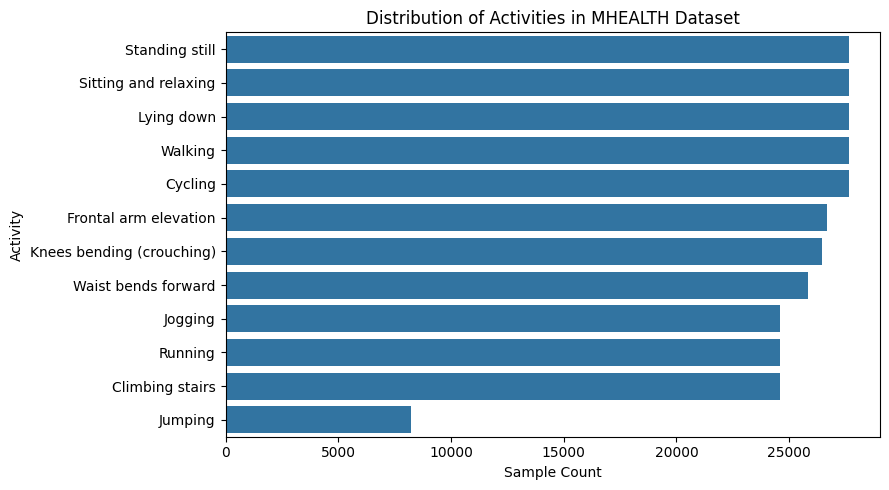

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
# Create a dictionary to map label numbers to activity names
activity_map = {
    #0: "Little/no activity",
    1: "Standing still",
    2: "Sitting and relaxing",
    3: "Lying down",
    4: "Walking",
    5: "Climbing stairs",
    6: "Waist bends forward",
    7: "Frontal arm elevation",
    8: "Knees bending (crouching)",
    9: "Cycling",
    10: "Jogging",
    11: "Running",
    12: "Jumping"
}

# Create a new column with readable activity names
df['activity_name'] = df['activity_label'].map(activity_map)

# Preview the result
df[['activity_label', 'activity_name']].head()
plt.figure(figsize=(9, 5))
sns.countplot(data=df, y='activity_name', order=df['activity_name'].value_counts().index)
plt.title("Distribution of Activities in MHEALTH Dataset")
plt.xlabel("Sample Count")
plt.ylabel("Activity")
plt.tight_layout()
plt.show()


Epoch 1 - Loss: 0.6753
Epoch 2 - Loss: 0.7339
Epoch 3 - Loss: 0.3178
Epoch 4 - Loss: 0.0916
Epoch 5 - Loss: 0.0364
Epoch 6 - Loss: 0.0391
Epoch 7 - Loss: 0.0503
Epoch 8 - Loss: 0.0387
Epoch 9 - Loss: 0.0193
Epoch 10 - Loss: 0.0110
Epoch 11 - Loss: 0.0110
Epoch 12 - Loss: 0.0038
Epoch 13 - Loss: 0.0034
Epoch 14 - Loss: 0.0025
Epoch 15 - Loss: 0.0017
Epoch 16 - Loss: 0.0009
Epoch 17 - Loss: 0.0008
Epoch 18 - Loss: 0.0009
Epoch 19 - Loss: 0.0009
Epoch 20 - Loss: 0.0010


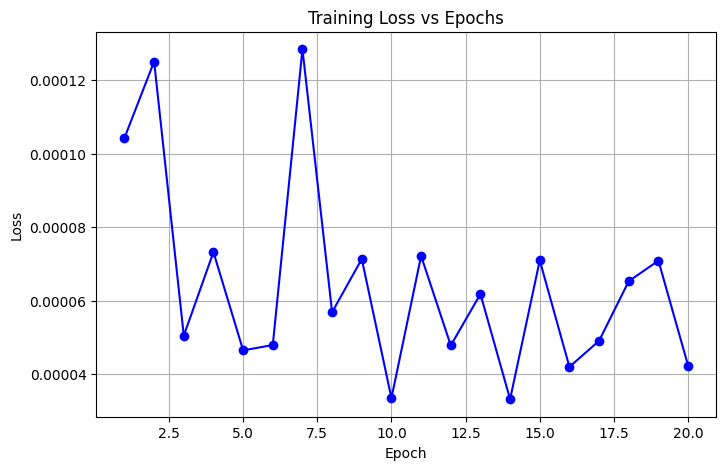

In [22]:
# Define 1D CNN Model
class InjuryRisk1DCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(InjuryRisk1DCNN, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(2)

        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(128)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(2)

        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(256)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.AdaptiveMaxPool1d(1)

        self.fc1 = nn.Linear(256, 128)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu3(self.bn3(self.conv3(x))))
        x = torch.flatten(x, 1)
        x = self.dropout(self.fc1(x))
        return self.fc2(x)

# Setup Training

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = InjuryRisk1DCNN(input_channels=X_train.shape[1], num_classes=2).to(device)

# Use Class Weights in Loss
class_counts = np.bincount(y_train.numpy())
class_weights = torch.tensor([class_counts[1], class_counts[0]]).float().to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1} - Loss: {running_loss:.4f}")

# After training: plot
plt.figure(figsize=(8,5))
plt.plot(range(1, num_epochs+1), train_losses, marker='o', color='b')
plt.title('Training Loss vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


# Evaluation
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for xb, yb in val_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        pred_labels = torch.argmax(preds, dim=1)
        y_true.extend(yb.cpu().numpy())
        y_pred.extend(pred_labels.cpu().numpy())



📊 Final Evaluation:
Accuracy : 0.8682
Precision: 1.0000
Recall   : 0.8682
F1 Score : 0.9295

Confusion matrix:
 [[   0    0]
 [ 769 5066]]


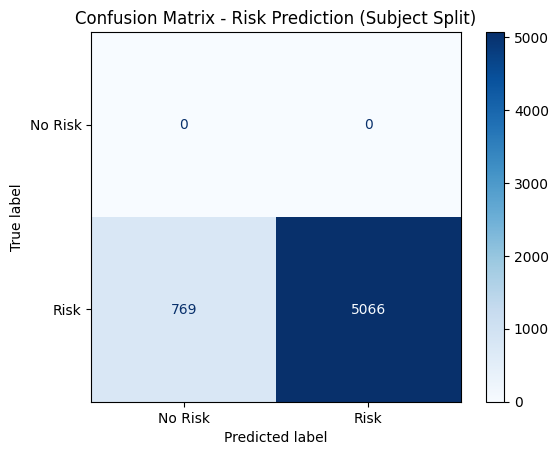

In [12]:
# Metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("\n📊 Final Evaluation:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion matrix:\n", cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Risk", "Risk"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Risk Prediction (Subject Split)")
plt.show()


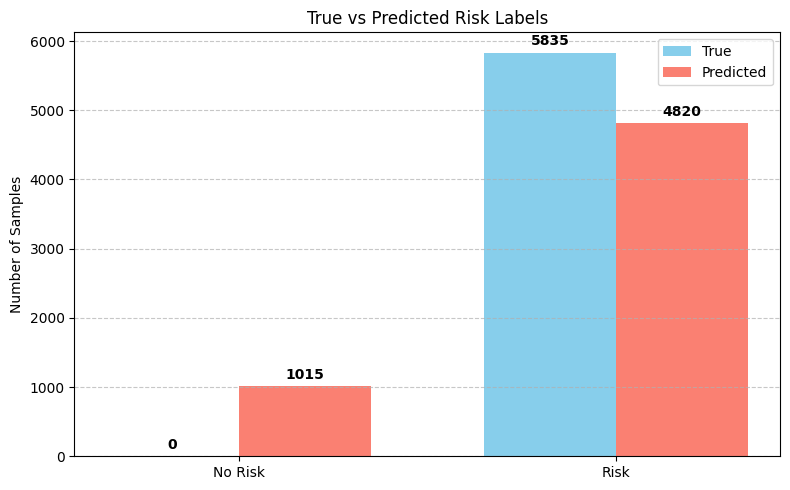

In [26]:

# ========================================
# ✅ 3. Plot Bar Graph: True vs Predicted Labels
# ========================================

classes = ["No Risk", "Risk"]
true_counts = np.bincount(y_true)
pred_counts = np.bincount(y_pred)

x = np.arange(len(classes))
width = 0.35

fig, ax = plt.subplots(figsize=(8,5))
rects1 = ax.bar(x - width/2, true_counts, width, label='True', color='skyblue')
rects2 = ax.bar(x + width/2, pred_counts, width, label='Predicted', color='salmon')

ax.set_ylabel('Number of Samples')
ax.set_title('True vs Predicted Risk Labels')
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.legend()
# Add counts on top of bars
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{int(height)}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

add_labels(rects1)
add_labels(rects2)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


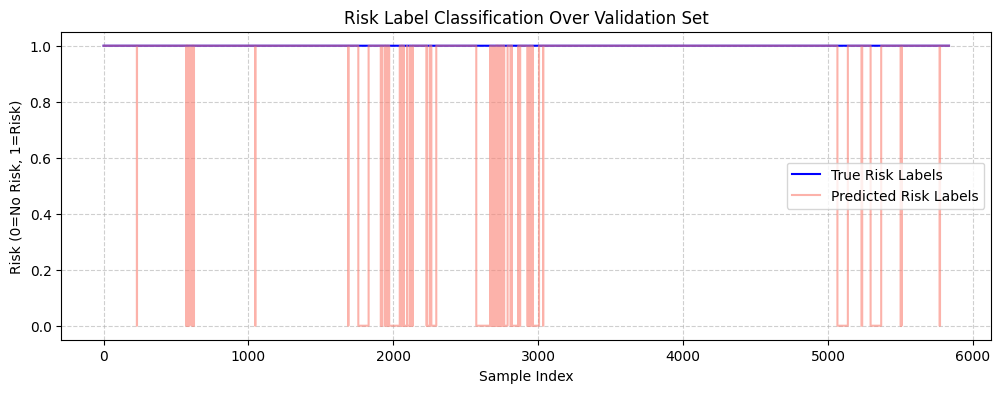

In [19]:
plt.figure(figsize=(12, 4))
plt.plot(y_true, label='True Risk Labels', drawstyle='steps-post', color='blue')
plt.plot(y_pred, label='Predicted Risk Labels', drawstyle='steps-post', color='salmon', alpha=0.6)
plt.title('Risk Label Classification Over Validation Set')
plt.xlabel('Sample Index')
plt.ylabel('Risk (0=No Risk, 1=Risk)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()
